## Resumen Abstractivo

Los resúmenes por abstracción son un tipo de resumen en el que las técnicas de tratamiento del lenguaje natural empleadas son mucho más sofisticadas. Esto es debido a que los resúmenes por abstracción
no se limitan a extraer fragmentos relevantes de un texto, sino que analizan el texto con
mayor profundidad para poder comprenderlo y poder generar un nuevo resumen a partir
de la información analizada de la fuente.
Si el hecho de que exista la necesidad de comprender el texto de forma más profunda ya
hace que el problema sea más difícil, a esto se le añade la dificultad de generar texto
desde cero a partir de una base de conocimiento.
El resumen por abstracción es por lo tanto similar al método que emplearía un ser
humano para hacer un resumen propio de un texto.


## Librerias

In [27]:
#Librerias
import pandas as pd
import numpy as np
import sqlite3
import sqlalchemy 
##NLTK
#nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
#Importamos las funciones vistas en clase
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
stopSpanish=set(stopwords.words('spanish'))
##split
from sklearn.model_selection import train_test_split
#base line
from nltk.cluster.util import cosine_distance
import networkx as nx
import scipy.sparse


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Funciones

In [28]:
#Funciones
#Analisis palabras
def contadorP(listaTxt,corte):
    opinion_len = pd.Series([len(op.split()) for op in listaTxt])
    opinion_len[opinion_len<corte ].plot(kind='box')
    print(opinion_len.describe())
#NLTK
def limpiarNLTK(listaTxt,categoria,n_noticias):   
    resumen=[]
    for i in range (n_noticias):
        text_tokens = word_tokenize(listaTxt[i])
        tokens_without_sw = [word for word in text_tokens if not word in stopSpanish]
        tokens_without_sw = [word.lower() for word in tokens_without_sw if word.isalpha()]
        resumen.append(' '.join(tokens_without_sw))
    return resumen
# recortador de textos
def Recorte(DF,minp=100,maxp=500):
    listaTxt=DF["articulo"]
    opinion_len = pd.Series([len(op.split()) for op in listaTxt])
    DF2 = (DF.drop(DF[opinion_len<=minp].index | DF[opinion_len>maxp].index)).reset_index(drop=True)
    return DF2
  

### Conexios DB

In [ ]:
def conexiondb(dbfile):
    try:
        con = sqlite3.connect(dbfile)    
    except Exception as e:
        print(e)
    #Now in order to read in pandas dataframe we need to know table name
    cursor = con.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    #print(f"Table Name : {cursor.fetchall()}")
    Names=cursor.fetchall()
    df=[]
    for db in Names:
        TableName=db[0]
        df.append(pd.read_sql_query('SELECT * FROM '+TableName, con))
    con.close()
    return df

### Base line

In [7]:
#base line
def read_article2(filedata):    
    article = filedata.split(".") #separa los textos por puntos que hay
    sentences = []

    for sentence in article:
        sentence=sentence.replace("  ","")
        tokens=sentence.replace("[^a-zA-Z]", " ").split(" ")
        if len(tokens)>3:
            sentences.append(tokens)
    sentences.pop()  
    return sentences

def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
    all_words = list(set(sent1 + sent2))
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
    return 1 - cosine_distance(vector1, vector2)
 
def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
 
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue 
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)
    return similarity_matrix

## Main

In [25]:
##Cargando data
#dbfile = '/content/drive/MyDrive/Datos/NoticiasReforma2009.db' #emilio drive
dbfile="/content/drive/Othercomputers/My Computer/Computo Estadistico/PIA-CD2/NoticiasReforma2009.db" #david drive
#dbfile='D:/Computo Estadistico/PIA-CD2/NoticiasReforma2009.db' #david pc
DATA=conexiondb(dbfile)
df_N2009=DATA[1]

##Preproceso
#Se eliminan las columnas no ocupamos
df_N2009 = df_N2009[['titulo','resumen','articulo']].copy()
n_noticias=(df_N2009).shape[0]

Contador de palabras antes de limpiar

count    61035.000000
mean        23.366052
std         18.364978
min          0.000000
25%         22.000000
50%         24.000000
75%         25.000000
max       1449.000000
dtype: float64


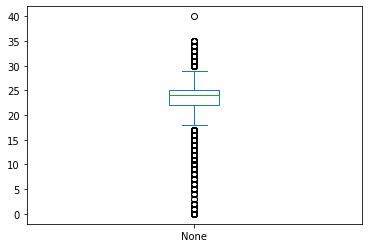

In [22]:
##Resumen
contadorP(df_N2009["resumen"],50)

count    61035.00000
mean       328.52791
std        199.53930
min          4.00000
25%        197.00000
50%        281.00000
75%        398.00000
max       5026.00000
dtype: float64


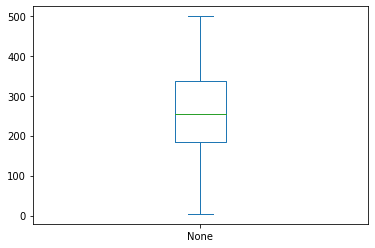

In [21]:
##Articulo
contadorP(df_N2009["articulo"],500)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead


count    45086.000000
mean       244.974959
std         77.828238
min        101.000000
25%        181.000000
50%        240.000000
75%        307.000000
max        400.000000
dtype: float64


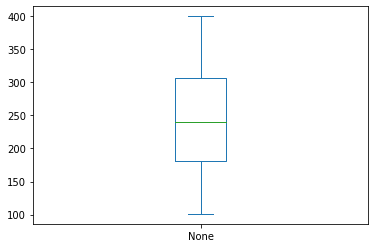

In [29]:
##removemos todas las noticias con menos de  100 palabras y maximo 400
df_N2009v2=Recorte(df_N2009,minp=100,maxp=400)
contadorP(df_N2009v2["articulo"],500)
n_noticias=(df_N2009v2).shape[0]

In [31]:
#Limpiar nltk
categoria="articulo"
resumenA=limpiarNLTK(df_N2009v2[categoria],categoria,n_noticias)
categoria="resumen"
resumenR=limpiarNLTK(df_N2009v2[categoria],categoria,n_noticias)



Contador de palabras despues de limpiar

count    45086.000000
mean        13.039125
std          4.294976
min          0.000000
25%         12.000000
50%         13.000000
75%         14.000000
max        229.000000
dtype: float64


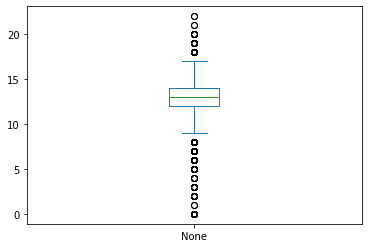

In [35]:
##Resumen
contadorP(resumenR,30)

count    45086.000000
mean       127.681298
std         40.270541
min         43.000000
25%         95.000000
50%        125.000000
75%        159.000000
max        323.000000
dtype: float64


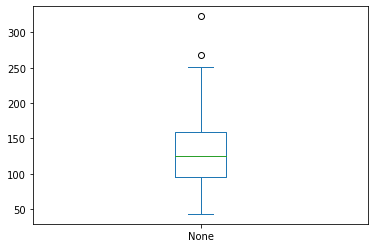

In [36]:
##Articulo
contadorP(resumenA,400)


In [37]:
#Split
X_train, X_test, y_train, y_test  = train_test_split(resumenA,resumenR,test_size=0.2, random_state=20, shuffle=True)

In [38]:
def generate_summary(Texto, top_n=5,c=0,MaxP=400):
    #print(c)
    stop_words = stopwords.words('spanish')
    summarize_text = []
    # Step 1 - Read text anc split it
    sentences =  read_article2(Texto) #recibe texto por texto
    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)
    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph,  max_iter=MaxP)

    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)    
    #print("Indexes of top ranked_sentence order are ", ranked_sentence)    
    
    if len(sentences)>top_n:
        for i in range(top_n):
          summarize_text.append(" ".join(ranked_sentence[i][1]))
    else:
        for i in range(round(len(sentences)/2)-1):
          summarize_text.append(" ".join(ranked_sentence[i][1]))

    Resumen=' '.join(summarize_text)

    # Step 5 - Offcourse, output the summarize texr
    #print("Summarize Text: \n", ". ".join(summarize_text))
    return Resumen


In [40]:
resumenPred=[]
c=0
for i in df_N2009v2["articulo"]:
    resumenPred.append(generate_summary( i, 4,c,400))
    if c%1000==0:
        print(c)
    c=c+1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000


In [42]:
print(df_N2009v2["articulo"][0])
print(df_N2009v2["resumen"][0])
print(resumenPred[0])


                        Fallan reproductores Zune de Microsoft En el Año Nuevo los usuarios del popular reproductor de música Zune de la Microsoft Corp. no pudieron escuchar nada.Miles de reproductores Zune de Microsoft -la respuesta del gigante del software a los populares iPod de la empresa Apple Inc.- dejaron de funcionar inesperadamente la noche de ayer y mostraban a los usuarios un mensaje de error que llevó a referencias del "Colapso del 2000 para los Zunes". El problema surgió cuando la gente intentó hacer funcionar sus aparatos.Los usuarios buscaron en los foros de ayuda de Microsoft para Zune e inundaron el portal con más de 2 mil 500 mensajes.Anoche, la empresa, con sede en Redmond, Washington, informó que el problema afectó sólo a los modelos de 30 gigabytes de Zune y fue provocado por un problema del reloj interno.Microsoft esperaba que el problema se resuelva tan pronto como los relojes pasen de fecha al 1 de enero, aunque los usuarios deberán adoptar varias medidas antes